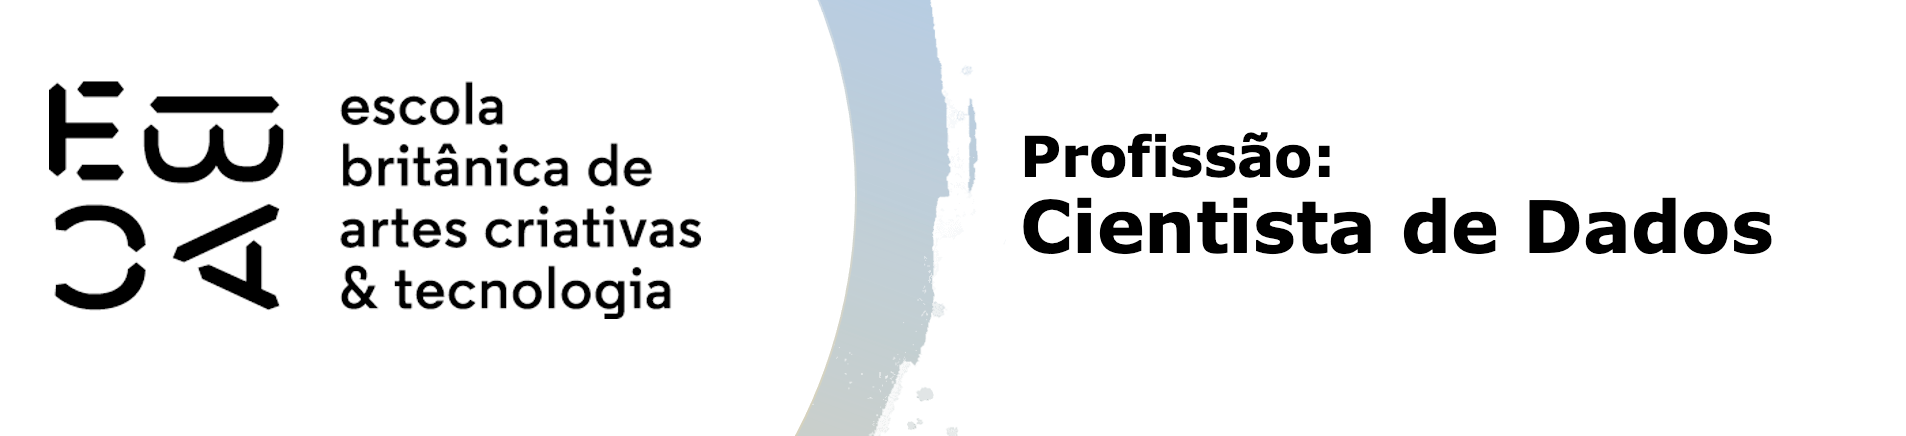

## Agrupamento hierárquico

Vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

Ela trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

Abaixo, a lista de variáveis com sua respectiva descrição:

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

Vamos iniciar instalando e carregando os pacotes necessários. Em seguida, vamos carregar e visualizar os dados:

In [7]:
#instalando o pacote gower:
!pip install gower

In [68]:
#carregando pacotes:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram #linkage- agrupamento
from gower import gower_matrix
from scipy.spatial.distance import pdist, squareform
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [9]:
#leitura do arquivo ftr:
df = pd.read_feather('online_shoppers_intention.ftr')

In [10]:
#exibindo df:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## Análise descritiva

Faremos uma análise descritiva das variáveis. Para isso:

- Verificaremos a distribuição das variáveis;
- Veficaremos se há *missings* e o que fazer com eles;
- Faremos os tratamentos que acharmos pertinentes.

In [12]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


*De acordo com o describe acima, temos 12330 observações para todas as variáveis, logo, não há valores faltantes no nosso df. Não havendo, não é necessário tratamento.*

Vejamos agora as interpretações retiradas da tabela acima:

- As **páginas administrativas e informacionais** tem uma média muito baixa de acessos e também de tempo gasto nelas, já as **páginas de produtos** apresentam boas médias.

- A **taxa média de rejeição (BounceRates) é baixa**, o que significa que a maioria dos analisados realiza mais de uma interação durante a sessão, o que concorda com a **baixa média de taxa de saída**, que sugere que os visitantes continuam a navegação pelo site após acessar uma página específica.

- A média de **PageValues** sendo 5.88 indica que, em média, as páginas visitadas antes de uma conversão possuem um valor de cerca de 5.88 em termos de contribuição para a receita. No entanto, a alta dispersão, com um desvio padrão de 18.56, revela que há uma grande variabilidade nos valores de PageValues. Isso sugere que algumas páginas têm um impacto muito maior no processo de conversão, enquanto outras podem ter pouco ou nenhum impacto.

- **A média de SpecialDay sendo 0,06 indica que, em geral, as sessões de navegação analisadas não estão muito próximas a datas especiais** e o desvio padrão de 0,19, indica que há uma baixa variação nos valores dessa variável.

- **Browser**: O categorizado como 2 é o mais frequente.

- **Trafic Type**: O categorizado como 2 é o mais frequente.

  

Algumas variáveis são mais dificeis de interpretar através do *describe()*, e outras, não numéricas, nem aparecem nessa descrição, logo, veremos o *value_counts()* para aquelas que acharmos pertinentes:

In [14]:
#Vamos observar melhor como é distribuída a variável 'Region':
df['Region'].value_counts()

Region
1    4780
3    2403
4    1182
2    1136
6     805
7     761
9     511
8     434
5     318
Name: count, dtype: int64

Temos 9 categorias para região, sendo as regiões 1 e 3, responsáveis por mais de 50% da frequência.

Agora, vejamos quais variáveis estão presentes no nosso df e ainda precisam de tratamento:

In [17]:
df.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

Para realizar essa análise, precisamos que as variáveis estejam no formato numérico ou booleano. Logo, vamos criar dummies para as variáveis no qual for pertinente.

Aqui enfrentamos um problema, pois, quando utilizamos métodos de distâncias, pode ocorrer uma interpretação errada para os meses caso transformemos eles em variáveis numéricas, pois 12 (dezembro) é um número muito maior que (1) janeiro e na realidade, não há essa distância toda entre eles, visto que janeiro é na sequência de dezembro. Por isso no próximo passo, *faremos a criação de dummies para os meses, caso julgarmos essa variável como indispensável*. 

*Também faremos a criação de dummies para o tipo de visitante.*

___

## Variáveis de agrupamento

Aqui iremos listar as variáveis que vamos querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Variáveis que descrevam o padrão de navegação na sessão.
- Variáveis que indiquem a característica da data.

Vamos listar quais são nossas variáveis:

In [21]:
df.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

Há uma dificil tarefa de escolha aqui, uma vez que é necessário considerar que cada variável escolhida aumenta o tempo de calculo da matriz gower. Logo, é necessário pensar também na sobrecarga e através disso, escolher apenas as aqui consideradas 'mais relevantes', ou então, quando há uma forte correlação entre elas como BounceRates e ExitRates consideramos manter apenas uma, assim como Administrative e Administrative Duration.

Outra alternativa seria o método PCA, não utilizaremos agora pois não é o foco, mas seria uma interessante solução. 

In [23]:
# Selecionando as variáveis escolhidas
df_1 = df[['Revenue', 'BounceRates', 'Administrative_Duration', 'Informational_Duration', 
                  'ProductRelated_Duration', 'PageValues', 'SpecialDay', 'Weekend', 
                   'Month', 'VisitorType']]

# Exibindo as primeiras linhas do novo DataFrame
df_1.head()

,Revenue,BounceRates,Administrative_Duration,Informational_Duration,ProductRelated_Duration,PageValues,SpecialDay,Weekend,Month,VisitorType
0,False,0.20,0.0,0.0,0.000000,0.0,0.0,False,Feb,Returning_Visitor
1,False,0.00,0.0,0.0,64.000000,0.0,0.0,False,Feb,Returning_Visitor
2,False,0.20,0.0,0.0,0.000000,0.0,0.0,False,Feb,Returning_Visitor
3,False,0.05,0.0,0.0,2.666667,0.0,0.0,False,Feb,Returning_Visitor
4,False,0.02,0.0,0.0,627.500000,0.0,0.0,True,Feb,Returning_Visitor


Escolhidas as variáveis, vamos separar Revenue e BounceRates das demais:

In [25]:
#seleciona a partir da segunda variável dentre o escopo selecionado acima
variaveis = df_1.columns.values[2:]
variaveis

array(['Administrative_Duration', 'Informational_Duration',
       'ProductRelated_Duration', 'PageValues', 'SpecialDay', 'Weekend',
       'Month', 'VisitorType'], dtype=object)

Agora vamos selecionais as qualitativas (duas últimas) para tratamento de obtenção de dummies:

In [27]:
#selecionando as duas últimas que são qualitativas:
variaveis_cat = variaveis[-2:]
variaveis_cat

array(['Month', 'VisitorType'], dtype=object)

In [28]:
#transformando em dummies as que precisam de transformação (visitortype e month) e armazenando em df_2
df_2 = pd.get_dummies(df_1[variaveis].dropna())
df_2.head()

,Administrative_Duration,Informational_Duration,ProductRelated_Duration,PageValues,SpecialDay,Weekend,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0.0,0.0,0.000000,0.0,0.0,False,False,False,True,False,False,False,False,False,False,False,False,False,True
1,0.0,0.0,64.000000,0.0,0.0,False,False,False,True,False,False,False,False,False,False,False,False,False,True
2,0.0,0.0,0.000000,0.0,0.0,False,False,False,True,False,False,False,False,False,False,False,False,False,True
3,0.0,0.0,2.666667,0.0,0.0,False,False,False,True,False,False,False,False,False,False,False,False,False,True
4,0.0,0.0,627.500000,0.0,0.0,True,False,False,True,False,False,False,False,False,False,False,False,False,True


In [29]:
#exibindo a nomenclatura das colunas do df_2, que contém as novas dummies:
df_2.columns.values

array(['Administrative_Duration', 'Informational_Duration',
       'ProductRelated_Duration', 'PageValues', 'SpecialDay', 'Weekend',
       'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June',
       'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
       'VisitorType_New_Visitor', 'VisitorType_Other',
       'VisitorType_Returning_Visitor'], dtype=object)

In [30]:
#Identificando quais colunas foram geradas a partir das variáveis categóricas originais Month e VisitorType:
vars_cat = [True if x in {'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June',
       'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 
       'VisitorType_New_Visitor', 'VisitorType_Other', 
       'VisitorType_Returning_Visitor'} else False for x in df_2.columns]

Agora que temos nosso df_2 finalizado, com as colunas que queremos analisar nos formatos adequados, vamos padronizar as variáveis não qualitativas e verificar o shape do nosso df_2 ajustado:

In [32]:
# Selecionando as colunas a serem padronizadas
cols_to_standardize = ['Administrative_Duration', 'Informational_Duration', 
                       'ProductRelated_Duration', 'PageValues']

# Aplicando a padronização diretamente no DataFrame df_2
scaler = StandardScaler()
df_2[cols_to_standardize] = scaler.fit_transform(df_2[cols_to_standardize])

In [33]:
df_2.shape

(12330, 19)

Temos aqui 19 colunas, um número relativamente grande, se formos pensar que para realizar a matriz de gower tem-se o produto de linhas por colunas. Entretanto, nesse momento, utilizaremos assim. Uma estratégia que reduziria significativamente o número de colunas seria retirar as variáveis derivadas de mês, uma vez que são 12 meses e portanto, 12 colunas. 

Nesse momento, não optaremos por fazer essa remoção, iremos seguir adiante assim.
___

## Número de grupos

Nesta atividade, adotaremos uma abordagem pragmática para **avaliar agrupamentos hierárquicos com 3 e 4 grupos**, alinhados com as expectativas e estratégias definidas pelo diretor da empresa.

Para realizar uma análise de similaridade entre as observações no DataFrame, **foi necessário criar uma matriz de distância utilizando a métrica de Gower**. Essa métrica é **ideal para lidar com variáveis mistas**, pois considera tanto variáveis numéricas quanto categóricas de forma apropriada. 

*No código abaixo, a matriz de distância é construída a partir do DataFrame df_2, com a ajuda da lista booleana vars_cat, que identifica as colunas categóricas, garantindo que as distâncias sejam calculadas de maneira correta:*

In [36]:
#criando a matriz de distância:
distancia_gower = gower_matrix(df_2, cat_features=vars_cat)

In [37]:
#colocando a matriz de distancia no formato que o algoritmo precisa
gdv = squareform(distancia_gower,force='tovector')

In [38]:
#exibindo quantidade de elementos da nossa matriz:
gdv.shape

(76008285,)

Agora, utilizaremos a matriz de distância para realizar um agrupamento hierárquico com o **método complete linkage, que une grupos com base na maior distância entre seus elementos.** 

O resultado é armazenado em uma matriz de ligação, posteriormente convertida em um DataFrame para facilitar a visualização das fusões, distâncias e tamanhos dos grupos formados:

In [40]:
Z = linkage(gdv, method='complete')
Z_df = pd.DataFrame(Z,columns=['id1','id2','dist','n'])
Z_df.head()

,id1,id2,dist,n
0,0.0,2.0,0.0,2.0
1,16.0,12330.0,0.0,3.0
2,21.0,12331.0,0.0,4.0
3,64.0,12332.0,0.0,5.0
4,70.0,12333.0,0.0,6.0


Dendograma gerado com base na matriz acima:

Leaves = 10674


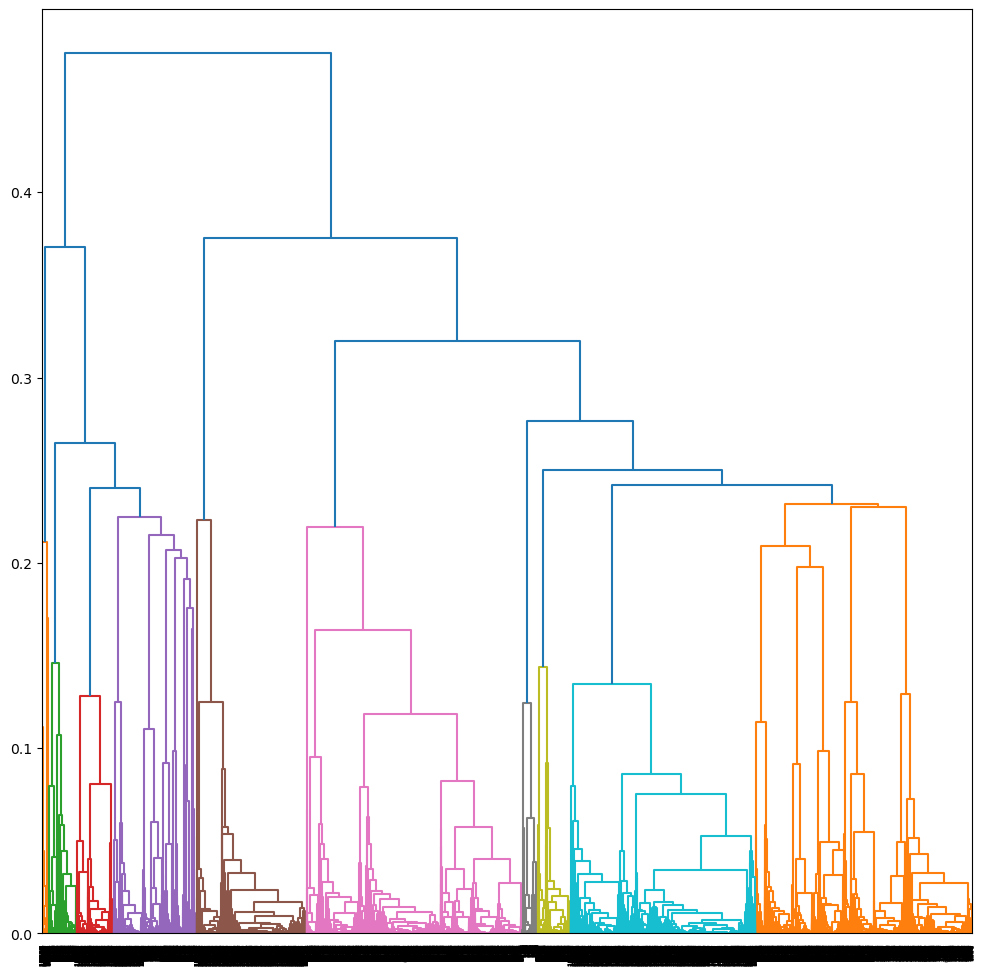

In [42]:
fig,axs = plt.subplots(1,1,figsize=(12,12))
dn = dendrogram(Z, truncate_mode='level',p=30,show_leaf_counts=True,ax=axs, color_threshold=.24)
print(f"Leaves = {len(dn['leaves'])}")

Observar esse dendograma pode ser um tanto quanto confuso, uma vez que ele 'sugere' a criação de diversos grupos. 

Pragmaticamente, como dito acima, utilizaremos 3 e 4 grupos, mas observando o dendograma também é mais plausível chegar nessas decisões do que em outras, uma vez que 4 grupos para explicar já parece ser suficiente e trazer uma melhor divisão. 

*Na etapa a seguir, criaremos esses grupos.*
___

## Construção e Análise Descritiva para 3 e 4 Grupos:

In [45]:
# Criando 3 grupos
df_2 ['3_grupos'] = fcluster(Z, t=3, criterion='maxclust')

# Criando 4 grupos
df_2 ['4_grupos'] = fcluster(Z, t=4, criterion='maxclust')

In [46]:
# Selecionando as colunas 'BounceRates' e 'Revenue' de df_1
columns_to_add = df_1[['BounceRates', 'Revenue']]

# Garantindo que os índices estão alinhados e fazendo a junção das colunas selecionadas ao df_2
df_3 = df_2.join(columns_to_add)

# Exibindo as primeiras linhas do DataFrame resultante
df_3.head()

,Administrative_Duration,Informational_Duration,ProductRelated_Duration,PageValues,SpecialDay,Weekend,Month_Aug,Month_Dec,Month_Feb,Month_Jul,...,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,3_grupos,4_grupos,BounceRates,Revenue
0,-0.457191,-0.244931,-0.624348,-0.317178,0.0,False,False,False,True,False,...,False,False,False,False,False,True,3,4,0.20,False
1,-0.457191,-0.244931,-0.590903,-0.317178,0.0,False,False,False,True,False,...,False,False,False,False,False,True,3,4,0.00,False
2,-0.457191,-0.244931,-0.624348,-0.317178,0.0,False,False,False,True,False,...,False,False,False,False,False,True,3,4,0.20,False
3,-0.457191,-0.244931,-0.622954,-0.317178,0.0,False,False,False,True,False,...,False,False,False,False,False,True,3,4,0.05,False
4,-0.457191,-0.244931,-0.296430,-0.317178,0.0,True,False,False,True,False,...,False,False,False,False,False,True,3,4,0.02,False


Agora que consolidamos as variáveis selecionadas no nosso escopo fazendo o tratamento delas, adicionamos a classificação dos grupos e as colunas de interesse (Revenue e BounceRates) ao novo DataFrame. 

Com isso, podemos agrupar os dados pela coluna Revenue e calcular a média de BounceRates para cada grupo, analisando como a taxa de rejeição se comporta dentro dos diferentes perfis de usuários:

In [48]:
# Agrupando por 'Revenue' e 'grupo', calculando a média de 'BounceRates'
result = df_3.groupby(['Revenue', '3_grupos'])['BounceRates'].mean().unstack().fillna(0)

# Formatando para exibir 2 casas decimais
result.style.format("{:.2f}")

3_grupos,1,2,3
Revenue,,,
False,0.01,0.03,0.03
True,0.00,0.00,0.01


*Observando a tabela acima, podemos realizar a seguinte interpretação:*

- **Os grupos 2 e 3 apresentam a maior e mesma taxa de rejeição entre os usuários que não convertem**, sendo necessário, talvez criar ações, para que sejam mais enganjados assim como o grupo 1.
  
- **Entre os usuários que convertem, todos os grupos apresentam taxas de rejeição muito baixas** (sendo 0 ou 0.01), o que indica que esses usuários tendem a navegar de forma mais consistente antes de concluir uma compra.

Vejamos como BounceRates se comporta para 4 grupos:

In [50]:
# Agrupando por 'Revenue' e 'grupo', calculando a média de 'BounceRates'
result = df_3.groupby(['Revenue', '4_grupos'])['BounceRates'].mean().unstack().fillna(0)

# Formatando para exibir 2 casas decimais
result.style.format("{:.2f}")


4_grupos,1,2,3,4
Revenue,,,,
False,0.05,0.01,0.03,0.03
True,0.00,0.00,0.00,0.01


*Para a tabela de 4 grupos, podemos ter a seguinte interpretação:*

- **Grupo 2 se destaca como o mais engajado**, apresentando a menor taxa de rejeição entre os usuários que não converteram.
  
- **Grupo 1 apresenta o maior índice de rejeição entre os usuários que não converteram**, seguido dos grupos 3 e 4, indicando a necessidade de ações para aumentar o engajamento.

  
- **Usuários que convertem:** Todos os grupos apresentam taxas de rejeição praticamente nulas, reforçando que os usuários que convertem são também mais enganjados. 

Vamos comparar as duas tabelas acima:

- Para *Revenue=False*, ambas possuem como menor taxa de rejeição 1%, o grupo 4, por 'quebrar' mais, possui como maior taxa de rejeição 5%, enquanto que para 3 grupos a maior é 3%.
- Para *Revenue=True* a maior taxa de rejeição é 1%, ou seja, muito baixa, sendo apenas para um grupo nos dois casos, o restante dos grupos fica com taxa nula de rejeição nos dois agrupamentos.

A vantagem de escolher 4 grupos seria facilitar a identificação do grupo que tem 5% de rejeição, mas como também é necessário melhorar as ações para aqueles grupos que apresentam 3%, talvez isso pudesse se encaixar e optarmos por 3 grupos, que traz mais simplicidade à nossa classificação. Portanto, iremos criar um modelo de regressão baseado em 3 grupos e observar sua acurácia.


## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

In [118]:
# selecionar variáveis explicativas (features) e eliminar missings:
X = df_3.dropna()[[ 'Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration',
                   'PageValues', 'SpecialDay', 'Weekend', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 
                   'Month_June','Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 
                   'VisitorType_New_Visitor', 'VisitorType_Other', 'VisitorType_Returning_Visitor']]

# Selecionar variável resposta (target)
y = df_3.dropna()['3_grupos']

In [120]:
#dividindo 80% pra treino e 20% pra teste:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2360873)

In [122]:
#configurando modelo inicial
clf = RandomForestClassifier(random_state=2360873, n_estimators=50)
#definindo o grid para encontrar o melhor valor de poda por custo-complexidade (de 0 a 01 andando de .01 em .01)
grid_parametros = {'ccp_alpha':np.arange(0, .1, .01)}


In [124]:
#busca pelos melhores hiperparâmetros (ccp_alpha) usando validação cruzada (4 folds, com cv=4)
grid = GridSearchCV(estimator = clf, param_grid=grid_parametros, cv=4, verbose=100)
grid.fit(X_train, y_train) 

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4; 1/10] START ccp_alpha=0.0..............................................
[CV 1/4; 1/10] END ...............ccp_alpha=0.0;, score=1.000 total time=   0.2s
[CV 2/4; 1/10] START ccp_alpha=0.0..............................................
[CV 2/4; 1/10] END ...............ccp_alpha=0.0;, score=1.000 total time=   0.1s
[CV 3/4; 1/10] START ccp_alpha=0.0..............................................
[CV 3/4; 1/10] END ...............ccp_alpha=0.0;, score=1.000 total time=   0.2s
[CV 4/4; 1/10] START ccp_alpha=0.0..............................................
[CV 4/4; 1/10] END ...............ccp_alpha=0.0;, score=1.000 total time=   0.2s
[CV 1/4; 2/10] START ccp_alpha=0.01.............................................
[CV 1/4; 2/10] END ..............ccp_alpha=0.01;, score=1.000 total time=   0.2s
[CV 2/4; 2/10] START ccp_alpha=0.01.............................................
[CV 2/4; 2/10] END ..............ccp_alpha=0.01;

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(n_estimators=50,
                                              random_state=2360873),
             param_grid={'ccp_alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])},
             verbose=100)

In [125]:
#resultados da grid
resultados = pd.DataFrame(grid.cv_results_)
resultados

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.252200,0.028625,0.014769,0.002834,0.0,{'ccp_alpha': 0.0},1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
1,0.236449,0.010871,0.010431,0.003249,0.01,{'ccp_alpha': 0.01},1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
2,0.233154,0.009926,0.014889,0.007612,0.02,{'ccp_alpha': 0.02},1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
3,0.231260,0.024549,0.006199,0.003580,0.03,{'ccp_alpha': 0.03},1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
4,0.228031,0.025467,0.007726,0.007117,0.04,{'ccp_alpha': 0.04},1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
5,0.217881,0.022344,0.007441,0.000783,0.05,{'ccp_alpha': 0.05},1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
6,0.209490,0.006106,0.009985,0.002850,0.06,{'ccp_alpha': 0.06},1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
7,0.230168,0.019603,0.011453,0.003349,0.07,{'ccp_alpha': 0.07},1.000000,0.996756,0.997161,0.993106,0.996756,0.002450,8
8,0.232774,0.008812,0.008168,0.001712,0.08,{'ccp_alpha': 0.08},0.996756,0.996756,0.997161,0.993106,0.995945,0.001647,9
9,0.215178,0.013229,0.007768,0.004764,0.09,{'ccp_alpha': 0.09},0.892944,0.892133,0.892133,0.892539,0.892437,0.000336,10


In [126]:
#identificar o melhor ccp_alpha
grid.best_params_

{'ccp_alpha': 0.0}

In [127]:
#treinamento final com o melhor modelo
clf = RandomForestClassifier(random_state=2360873, n_estimators=50, ccp_alpha=0.01)
clf.fit(X_train,y_train)

RandomForestClassifier(ccp_alpha=0.01, n_estimators=50, random_state=2360873)

In [128]:
#acurácia do modelo
clf.score(X_test, y_test)

1.0

Conseguimos uma ótima acurácia com esse modelo treinado através de 3 grupos, um acerto de 100% das classificações para o conjunto de teste. Podemos verificar também a matriz de confusão:

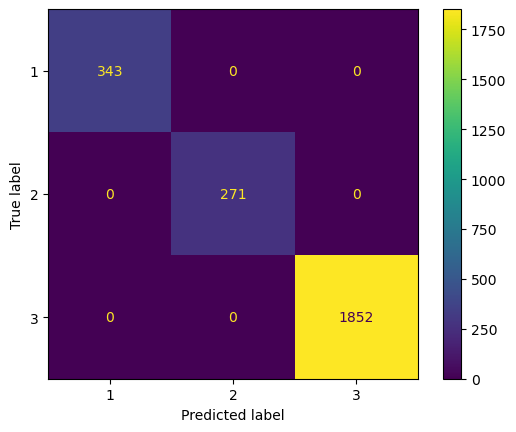

In [130]:
#matriz de confusão:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_).plot()

Finalizamos a nossa análise! Aqui temos uma acurária de 100%, o que é ótimo mas não comum, provavelmente nossos dados oportunizam esse tipo de comportamento do nosso modelo.
A nossa conclusão final aqui é que usuários mais enganjados convertem mais que usuários menos enganjados. 